## Table of Content
1. [Import Libraries](#Import-Libraries)
2. [TextRank](#TextRank)
3. [LexRank](#LexRank)
4. [TF-IDF](#TF-IDF)
5. [Evaluation](#Evaluation)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import collections
import re
import string
from heapq import nlargest
import warnings
warnings.filterwarnings("ignore")



from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics.pairwise import cosine_sAimilarity
from sklearn.cluster import KMeans
!pip install rouge
from rouge import Rouge

import nltk
# nltk.download('punkt') 
# nltk.download('stopwords')

from nltk.corpus import stopwords # Imports the stop words list from the NLTK corpus
from nltk.tokenize import sent_tokenize, word_tokenize # Imports the sentence tokenizer and word tokenizer 
from nltk.cluster.util import cosine_distance
from nltk.stem import PorterStemmer


## TextRank

In [2]:
#Text Rank Algorithm

# 1. Normalize the text
# 2. Symmetrize the text
# 3. Core Cosine Similarity
# 4. Sentence Similarity 
# 5. Build the similarity matrix
# 6. Page Rank
# 7. Get the top sentences
# 8. Summarize the text




MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "

def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)

def symmetrize(a):
    """
    Return a symmetrized version of NumPy array a.

    Values 0 are replaced by the array value at the symmetric
    position (with respect to the diagonal), i.e. if a_ij = 0,
    then the returned array a' is such that a'_ij = a_ji.

    Diagonal values are left untouched.

    a -- square NumPy array, such that a_ij = 0 or a_ji = 0, 
    for i != j.
    """
    return a + a.T - np.diag(a.diagonal())





def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)





def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []

    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]

    all_words = list(set(sent1 + sent2))

    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1

    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1

    return core_cosine_similarity(vector1, vector2)





def build_similarity_matrix(sentences, stopwords=None):
    # create an empty similarity matrix
    sm = np.zeros([len(sentences), len(sentences)])

    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:
                continue

            sm[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

    # Get Symmeric matrix
    sm = symmetrize(sm)

    # Normalize matrix by column
    norm = np.sum(sm, axis=0)
    sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

    return sm_norm




def run_page_rank(similarity_matrix):

    # constants
    damping = 0.85  # damping coefficient, usually is .85
    min_diff = 1e-5  # convergence threshold
    steps = 100  # iteration steps

    pr_vector = np.array([1] * len(similarity_matrix))

    # Iteration
    previous_pr = 0
    for epoch in range(steps):
        pr_vector = (1 - damping) + damping * np.matmul(similarity_matrix, pr_vector)
        if abs(previous_pr - sum(pr_vector)) < min_diff:
            break
        else:
            previous_pr = sum(pr_vector)

    return pr_vector

def get_top_sentences(pr_vector, sentences, number=3):

    top_sentences = []

    if pr_vector is not None:

        sorted_pr = np.argsort(pr_vector)
        sorted_pr = list(sorted_pr)
        sorted_pr.reverse()

        index = 0
        for epoch in range(number):
            sent = sentences[sorted_pr[index]]
            sent = normalize_whitespace(sent)
            top_sentences.append(sent)
            index += 1

    return top_sentences



def textrank_summarizer(text_str,n=5):
  sentences = sent_tokenize(text_str)
  tokenized_sentences = [word_tokenize(sent) for sent in sentences]
  sm_mat = build_similarity_matrix(tokenized_sentences)
  pr_vec = run_page_rank(sm_mat)
  ans = get_top_sentences(pr_vec,sentences,n)

  return " ".join(ans)




## LexRank

In [3]:

# Summarize using LexRank Algorithm

def lexrank_summarizer(text, n):

    # Tokenize the text into sentences and words
    sentences = sent_tokenize(text)
    words = word_tokenize(text)

    # Create a frequency table to keep the score of each word
    freq_table = dict()
    for word in words:
        word = word.lower()
        if word in stopwords.words('english'):
            continue
        if word in string.punctuation:
            continue
        if word in freq_table:
            freq_table[word] += 1
        else:
            freq_table[word] = 1

    # Assign a score to each sentence based on the frequency of words in the sentence
    sentence_value = dict()
    for sentence in sentences:
        for word, freq in freq_table.items():
            if word in sentence.lower():
                if sentence in sentence_value:
                    sentence_value[sentence] += freq
                else:
                    sentence_value[sentence] = freq

    # Find the top n sentences with the highest scores
    top_sentences = nlargest(n, sentence_value, key=sentence_value.get)

    # Print the top n sentences
    summary = ' '.join(top_sentences)
    return summary




## TF-IDF

In [4]:
# Clustering method Tf-idf 




def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens

def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
 
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    return clustering


def cluster_summarizer_TFIDF(text, n):

    # Tokenize the text into individual sentences
    sentences = sent_tokenize(text)

    # Cluster the sentences into n clusters
    clusters = cluster_texts(sentences, n)

    # Get the sentences for the clusters
    cluster_sentences = []
    for cluster in range(n):
        cluster_sentences.append(sentences[clusters[cluster][0]])

    # Print the sentences for the clusters
    summary = ' '.join(cluster_sentences)
    return summary



## Evaluation

Sample Testing

In [5]:

sample_news = "The US has " \
                "passed the peak on new coronavirus cases, " \
                "President Donald Trump said and predicted that " \
                "some states would reopen this month. " \
                "The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, " \
                "the highest for any country in the world. " \
                "At the daily White House coronavirus briefing on Wednesday, " \
                "Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors. " \
                "We'll be the comeback kids, all of us, Trump said. " \
                "We want to get our country back. " \
                "The US was going to produce soon excess ventilators, " \
                "which would be sent to other countries, the president said. " \
                "We're going to be sending them to Italy, we're going to be sending them to France, " \
                "we're going to be sending them to Spain where they have tremendous problems, " \
                "and other countries as we can. " \
                "We're also going to be sending gowns, protective gear, " \
                "over the next week or so, large amounts to Italy, " \
                "France, Spain, and other places. " \
                "Trump said the US was working with about 10 countries, " \
                "including Italy, Spain, France, " \
                "Germany, Japan, South Korea, Vietnam, and China, " \
                "on developing a vaccine against the coronavirus. " \
                "We're working with the rest of the world. " \
                "All they do is rip us off. " \
                "They rip us off left and right, Trump said. " \
                "We're working with many countries on the vaccine, " \
                "we're helping them out, and I think it's going to be good for them too. " \
                "We'll work with them. " \
                "They'll respect us more. " \
                "They're going to respect us more for doing it. " \
                "Hours earlier, New York Governor Andrew Cuomo said " \
                "the state's efforts at social distancing were working " \
                "and that hospitalizations had fallen to the level they were 21 days ago. " \
                "The number of people going into hospital " \
                "is down and that's the first real " \
                "hard indicator that we are turning the corner, " \
                "Cuomo said at his daily briefing. " \
                "Cuomo said the state was still reporting " \
                "between 2,000 and 2,500 new cases a day " \
                "and that the death toll was still " \
                "distressingly high at 752 on Tuesday. " \
                "But he said the numbers were somewhat " \
                "better than they had been. " \
                "The governor said he would extend " \
                "an executive order to keep non-essential businesses " \
                "and schools closed until May 15. " \
                "He said he would coordinate the reopening " \
                "of the state with other governors in the region. " \
                "I don't want to just reopen, " \
                "I want to reopen and be smart, " \
                "and I want to reopen and be safe, " \
                    


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vjkan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

LexRank Summarization

In [7]:
lexrank_summarizer(sample_news, 5)

"At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors. Trump said the US was working with about 10 countries, including Italy, Spain, France, Germany, Japan, South Korea, Vietnam, and China, on developing a vaccine against the coronavirus. The US has passed the peak on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month. Hours earlier, New York Governor Andrew Cuomo said the state's efforts at social distancing were working and that hospitalizations had fallen to the level they were 21 days ago. The US was going to produce soon excess ventilators, which would be sent to other countries, the president said."

Cluster Summarization using TF-IDF, Cosine Similarity and K-Means

In [8]:
cluster_summarizer_TFIDF(sample_news, 5)

"We'll work with them. We'll be the comeback kids, all of us, Trump said. We're going to be sending them to Italy, we're going to be sending them to France, we're going to be sending them to Spain where they have tremendous problems, and other countries as we can. The US has over 637,000 confirmed Covid-19 cases and over 30,826 deaths, the highest for any country in the world. The US has passed the peak on new coronavirus cases, President Donald Trump said and predicted that some states would reopen this month."

Summarization using TextRank

In [9]:
textrank_summarizer(sample_news, 5)

"We'll be the comeback kids, all of us, Trump said. The US was going to produce soon excess ventilators, which would be sent to other countries, the president said. We're working with many countries on the vaccine, we're helping them out, and I think it's going to be good for them too. We're also going to be sending gowns, protective gear, over the next week or so, large amounts to Italy, France, Spain, and other places. At the daily White House coronavirus briefing on Wednesday, Trump said new guidelines to reopen the country would be announced on Thursday after he speaks to governors."

## Testing

In [10]:

test_df=pd.read_csv('Resources/Raw_Data.csv')
test_df.head()

,Article,Summary,Category
0,Ad sales boost Time Warner profitQuarterly pro...,TimeWarner said fourth quarter sales rose 2% t...,business
1,Dollar gains on Greenspan speechThe dollar has...,The dollar has hit its highest level against t...,business
2,Yukos unit buyer faces loan claimThe owners of...,Yukos' owner Menatep Group says it will ask Ro...,business
3,High fuel prices hit BA's profitsBritish Airwa...,"Rod Eddington, BA's chief executive, said the ...",business
4,Pernod takeover talk lifts DomecqShares in UK ...,Pernod has reduced the debt it took on to fund...,business


In [11]:

test_df.shape

(2225, 3)

In [12]:

# Take Sample of 200 rows

test_df = test_df.sample(n=100, random_state=1)
test_df.shape

(100, 3)

In [13]:

test_articles = test_df['Article']
test_summaries = test_df['Summary']

# To List

test_articles = test_articles.tolist()
test_summaries = test_summaries.tolist()

In [14]:

# Display the size of theses lists

print(len(test_articles))
print(len(test_summaries))


100
100


In [15]:

# Predict Summary using all 4 methods, and store in a list

lexrank_summaries = []
cluster_summaries = []
textrank_summaries = []

for article in test_articles:

    lexrank_summaries.append(lexrank_summarizer(article, 5))
    cluster_summaries.append(cluster_summarizer_TFIDF(article, 5))
    textrank_summaries.append(textrank_summarizer(article, 5))


# Display the size of the lists

print(len(lexrank_summaries))
print(len(cluster_summaries))
print(len(textrank_summaries))



100
100
100


In [16]:
textrank_summaries[1]

'Collins\' ban is a result of her connection to the federal inquiry into the Balco doping scandal. "The CAS panel\'s decision confirms that those who violate the rules will be sanctioned as part of USADA\'s ongoing efforts to protect the rights of the overwhelming majority of US athletes that compete drug-free," said Madden. The US Anti-Doping Agency (USADA) decided to press charges against Collins in the summer. The USADA has built its cases on verbal evidence given to the federal investigation into Balco rather than test results. "Collins used these substances to enhance her performance and elude the drug testing that was available at the time."'

In [17]:
cluster_summaries[1]

"Collins' ban is a result of her connection to the federal inquiry into the Balco doping scandal. Collins banned in landmark caseSprinter Michelle Collins has received an eight-year ban for doping offences after a hearing at the North American Court of Arbitration for Sport (CAS).America's former world indoor 200m champion is the first athlete to be suspended without a positive drugs test or an admission of drugs use. The sprinter has consistently protested her innocence but the CAS has upheld USADA's findings. The US Anti-Doping Agency (USADA) decided to press charges against Collins in the summer. His hearing before the CSA has been rescheduled for June next year.Drug enforcement chiefs in the US have vowed to crack down on cheats."

In [18]:
lexrank_summaries[1]

'Collins banned in landmark caseSprinter Michelle Collins has received an eight-year ban for doping offences after a hearing at the North American Court of Arbitration for Sport (CAS).America\'s former world indoor 200m champion is the first athlete to be suspended without a positive drugs test or an admission of drugs use. "The CAS panel\'s decision confirms that those who violate the rules will be sanctioned as part of USADA\'s ongoing efforts to protect the rights of the overwhelming majority of US athletes that compete drug-free," said Madden. "The USADA has proved, beyond a reasonable doubt, that Collins took EPO, the testosterone/epitestosterone cream and THG," said a CAS statement. The USADA has built its cases on verbal evidence given to the federal investigation into Balco rather than test results. USADA chief executive officer Terry Madden said the action taken against Collins was further proof of that.'

In [19]:

# Calculate the Rouge Scores for each method

lexrank_rouge = []
cluster_rouge = []
textrank_rouge = []

rouge = Rouge()

for i in range(len(test_summaries)):
    lexrank_rouge.append(rouge.get_scores(lexrank_summaries[i], test_summaries[i]))
    cluster_rouge.append(rouge.get_scores(cluster_summaries[i], test_summaries[i]))
    textrank_rouge.append(rouge.get_scores(textrank_summaries[i], test_summaries[i]))




In [20]:

# Calculate the Average Rouge Scores for each method

lexrank_rouge_1 = []
lexrank_rouge_2 = []
lexrank_rouge_l = []

cluster_rouge_1 = []
cluster_rouge_2 = []
cluster_rouge_l = []

textrank_rouge_1 = []
textrank_rouge_2 = []
textrank_rouge_l = []

for i in range(len(test_summaries)):


    lexrank_rouge_1.append(lexrank_rouge[i][0]['rouge-1']['f'])
    lexrank_rouge_2.append(lexrank_rouge[i][0]['rouge-2']['f'])
    lexrank_rouge_l.append(lexrank_rouge[i][0]['rouge-l']['f'])

    cluster_rouge_1.append(cluster_rouge[i][0]['rouge-1']['f'])
    cluster_rouge_2.append(cluster_rouge[i][0]['rouge-2']['f'])
    cluster_rouge_l.append(cluster_rouge[i][0]['rouge-l']['f'])

    textrank_rouge_1.append(textrank_rouge[i][0]['rouge-1']['f'])
    textrank_rouge_2.append(textrank_rouge[i][0]['rouge-2']['f'])
    textrank_rouge_l.append(textrank_rouge[i][0]['rouge-l']['f'])




In [21]:

# For Cluster Method

cluster_rouge_1_avg = sum(cluster_rouge_1) / len(cluster_rouge_1)
cluster_rouge_2_avg = sum(cluster_rouge_2) / len(cluster_rouge_2)
cluster_rouge_l_avg = sum(cluster_rouge_l) / len(cluster_rouge_l)

print("Cluster Rouge-1 Average: ", cluster_rouge_1_avg)
print("Cluster Rouge-2 Average: ", cluster_rouge_2_avg)
print("Cluster Rouge-l Average: ", cluster_rouge_l_avg)


Cluster Rouge-1 Average:  0.557105995107114
Cluster Rouge-2 Average:  0.43412393590991244
Cluster Rouge-l Average:  0.5470719436621689


In [22]:

# For Lexrank Method

lexrank_rouge_1_avg = sum(lexrank_rouge_1) / len(lexrank_rouge_1)
lexrank_rouge_2_avg = sum(lexrank_rouge_2) / len(lexrank_rouge_2)
lexrank_rouge_l_avg = sum(lexrank_rouge_l) / len(lexrank_rouge_l)

print("Lexrank Rouge-1 Average: ", lexrank_rouge_1_avg)
print("Lexrank Rouge-2 Average: ", lexrank_rouge_2_avg)
print("Lexrank Rouge-l Average: ", lexrank_rouge_l_avg)


Lexrank Rouge-1 Average:  0.7149219200769649
Lexrank Rouge-2 Average:  0.6287265762080974
Lexrank Rouge-l Average:  0.7110302015296794


In [23]:

# For TextRank Method

textrank_rouge_1_avg = sum(textrank_rouge_1) / len(textrank_rouge_1)
textrank_rouge_2_avg = sum(textrank_rouge_2) / len(textrank_rouge_2)
textrank_rouge_l_avg = sum(textrank_rouge_l) / len(textrank_rouge_l)

print("TextRank Rouge-1 Average: ", textrank_rouge_1_avg)
print("TextRank Rouge-2 Average: ", textrank_rouge_2_avg)   
print("TextRank Rouge-l Average: ", textrank_rouge_l_avg)


TextRank Rouge-1 Average:  0.6311793574327406
TextRank Rouge-2 Average:  0.5285000046467588
TextRank Rouge-l Average:  0.6218071404673248


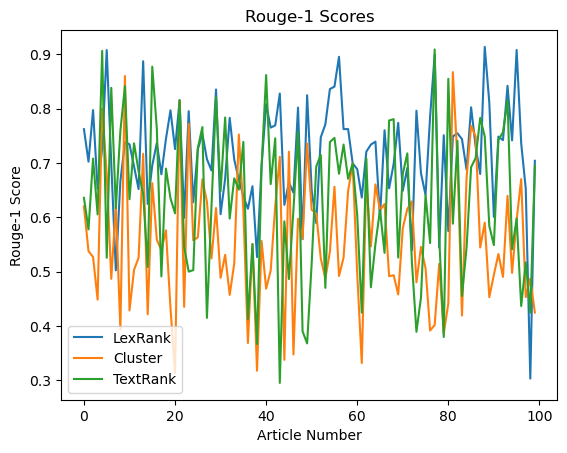

In [24]:

# Plot the Rouge Scores of Rouge1

import matplotlib.pyplot as plt

plt.plot(lexrank_rouge_1, label = "LexRank")
plt.plot(cluster_rouge_1, label = "Cluster")
plt.plot(textrank_rouge_1, label = "TextRank")
plt.legend()
plt.title("Rouge-1 Scores")
plt.xlabel("Article Number")
plt.ylabel("Rouge-1 Score")
plt.show()


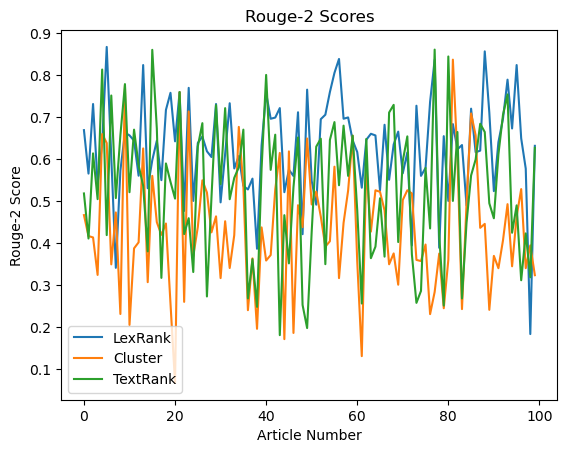

In [25]:

# Plot the Rouge Scores of Rouge2

plt.plot(lexrank_rouge_2, label = "LexRank")
plt.plot(cluster_rouge_2, label = "Cluster")
plt.plot(textrank_rouge_2, label = "TextRank")
plt.legend()
plt.title("Rouge-2 Scores")
plt.xlabel("Article Number")
plt.ylabel("Rouge-2 Score")
plt.show()


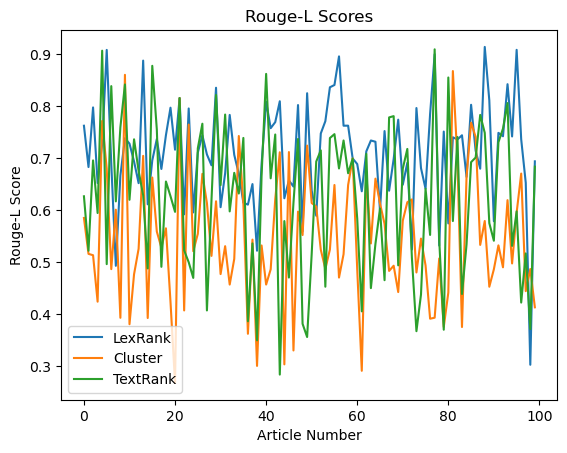

In [26]:
# Plot the Rouge Scores of RougeL

plt.plot(lexrank_rouge_l, label = "LexRank")
plt.plot(cluster_rouge_l, label = "Cluster")
plt.plot(textrank_rouge_l, label = "TextRank")
plt.legend()
plt.title("Rouge-L Scores")
plt.xlabel("Article Number")
plt.ylabel("Rouge-L Score")
plt.show()


In [27]:

# Summary of the Rouge Scores

print("Cluster Rouge-1 Average: ", cluster_rouge_1_avg)
print("Cluster Rouge-2 Average: ", cluster_rouge_2_avg)
print("Cluster Rouge-l Average: ", cluster_rouge_l_avg)

print("\nLexrank Rouge-1 Average: ", lexrank_rouge_1_avg)
print("Lexrank Rouge-2 Average: ", lexrank_rouge_2_avg)
print("Lexrank Rouge-l Average: ", lexrank_rouge_l_avg)

print("\nTextRank Rouge-1 Average: ", textrank_rouge_1_avg)
print("TextRank Rouge-2 Average: ", textrank_rouge_2_avg)
print("TextRank Rouge-l Average: ", textrank_rouge_l_avg)


Cluster Rouge-1 Average:  0.557105995107114
Cluster Rouge-2 Average:  0.43412393590991244
Cluster Rouge-l Average:  0.5470719436621689

Lexrank Rouge-1 Average:  0.7149219200769649
Lexrank Rouge-2 Average:  0.6287265762080974
Lexrank Rouge-l Average:  0.7110302015296794

TextRank Rouge-1 Average:  0.6311793574327406
TextRank Rouge-2 Average:  0.5285000046467588
TextRank Rouge-l Average:  0.6218071404673248
